# Reconstrucción de imágenes y eliminación de ruido usando Autoencoders

### Objetivo:  Comparar el desempeño de ambos modelos y analizar visualmente los resultados obtenidos.

### **Introducción a los Autoencoders**

#### ¿Qué es un Autoencoder? 🧠

Un autoencoder es un tipo de red neuronal artificial que se utiliza para aprender representaciones eficientes de datos de una manera no supervisada. Su objetivo principal es aprender una representación (codificación) para un conjunto de datos, típicamente para la **reducción de dimensionalidad** o la **extracción de características**.

La arquitectura de un autoencoder se compone de tres partes principales:

1.  **Codificador (Encoder):** Es la primera mitad de la red. Su función es tomar los datos de entrada y comprimirlos en una representación de menor dimensión, conocida como el **espacio latente** o *bottleneck* (cuello de botella). Esta representación latente captura las características más importantes de los datos.
2.  **Espacio Latente (Latent Space):** Es la capa central y más pequeña de la red, que contiene la representación comprimida de los datos de entrada. La dimensionalidad de este espacio es un hiperparámetro clave que define cuánta compresión se realiza.
3.  **Decodificador (Decoder):** Es la segunda mitad de la red. Su objetivo es tomar la representación comprimida del espacio latente y reconstruir los datos de entrada originales con la menor pérdida de información posible.

En este ejercicio, implementaremos dos variantes:

  * Parte A: Un **Autoencoder Básico** para comprimir y reconstruir imágenes.
  * Parte B: Un **Autoencoder de Eliminación de Ruido (Denoising)**, que aprende a crear imágenes limpias a partir de versiones ruidosas.


### **1. Importación de Librerías y Carga de Datos**

In [14]:
# Importar TensorFlow y Keras para la construcción de la red neuronal.
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist

# Importar NumPy para operaciones numéricas, especialmente para añadir ruido.
import numpy as np

# Importar Matplotlib para la visualización de las imágenes.
import matplotlib.pyplot as plt

# --- Carga del Dataset MNIST ---
# MNIST es un dataset clásico de dígitos escritos a mano (0-9).
# No necesitamos las etiquetas (y_train, y_test), por lo que las descartamos con '_'.
(x_train, _), (x_test, _) = mnist.load_data()


### **2. Preprocesamiento de los Datos: Normalización y Aplanamiento**

Antes de entrenar nuestra red, es fundamental preparar los datos. Realizaremos dos pasos clave:

1.  **Normalización:** Las imágenes del dataset MNIST tienen valores de píxeles que van de 0 (negro) a 255 (blanco). Para que el entrenamiento de la red neuronal sea más estable y eficiente, escalaremos estos valores a un rango entre 0 y 1. Esto se logra simplemente dividiendo todos los valores de los píxeles por 255.

2.  **Aplanamiento (Flattening):** Las capas que usaremos (`Dense`) esperan recibir los datos como un vector unidimensional. Por lo tanto, debemos transformar cada imagen, que es una matriz de 28x28 píxeles, en un vector plano de 784 elementos (28 \* 28 = 784).

Estos pasos aseguran que los datos estén en el formato y rango adecuados para ser procesados por la red.

In [15]:
# --- Normalización ---
# Convertimos el tipo de dato a 'float32' para permitir la división con decimales.
# Dividimos cada valor de píxel por 255 para escalar los datos al rango [0, 1].
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# --- Aplanamiento ---
# Cambiamos la forma de cada imagen de una matriz 2D (28, 28) a un vector 1D de 784 elementos.
# `np.prod(x_train.shape[1:])` calcula automáticamente el producto de las dimensiones (28*28).
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# Imprimimos las formas resultantes para verificar que el preprocesamiento fue correcto.
print("Forma del set de entrenamiento:", x_train.shape)
print("Forma del set de prueba:", x_test.shape)

Forma del set de entrenamiento: (60000, 784)
Forma del set de prueba: (10000, 784)


### **Parte A - Construcción del Autoencoder Básico**

Ahora construiremos el primer modelo. Utilizaremos la API Funcional de Keras, que ofrece gran flexibilidad para definir arquitecturas complejas.

La arquitectura será simétrica:

  * **Capa de Entrada:** Recibirá nuestros vectores aplanados de 784 dimensiones.
  * **Codificador:**
    1.  Una capa `Dense` con 128 neuronas y activación `ReLU` que reduce la dimensionalidad.
    2.  Una segunda capa `Dense` con 64 neuronas y activación `ReLU` que define nuestro **espacio latente**.
  * **Decodificador:**
    1.  Una capa `Dense` con 128 neuronas y activación `ReLU` que comienza a expandir la representación.
    2.  Una capa `Dense` de salida con 784 neuronas y activación `Sigmoid`.

**Elección de Funciones de Activación:**

  - **`ReLU` (Rectified Linear Unit):** Es una excelente opción para las capas ocultas, ya que es computacionalmente eficiente y ayuda a mitigar el problema del desvanecimiento del gradiente.
  - **`Sigmoid`:** Es ideal para la capa de salida porque produce valores en el rango (0, 1), que coincide perfectamente con el rango de nuestros datos de píxeles normalizados.


In [16]:
# Dimensión del espacio latente (nuestra representación comprimida).
encoding_dim = 64
# Dimensión de la entrada (28*28 = 784 píxeles).
input_dim = 784

# --- Definición de la arquitectura ---

# 1. Capa de entrada: Define la forma de los datos que recibirá el modelo.
input_img = Input(shape=(input_dim,))

# 2. Codificador: Mapea la entrada a la representación latente.
# Primera capa densa del codificador.
encoded = Dense(128, activation='relu')(input_img)
# Segunda capa densa que produce la codificación final de 64 dimensiones.
encoded = Dense(encoding_dim, activation='relu')(encoded)

# 3. Decodificador: Reconstruye la entrada a partir de la representación latente.
# Primera capa densa del decodificador.
decoded = Dense(128, activation='relu')(encoded)
# Capa de salida que reconstruye la imagen original de 784 píxeles.
decoded = Dense(input_dim, activation='sigmoid')(decoded)

# 4. Modelo completo: Se instancia el modelo especificando las capas de entrada y salida.
autoencoder = Model(input_img, decoded)

# Imprime un resumen de la arquitectura del modelo, mostrando las capas y el número de parámetros.
autoencoder.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 784)            │       101,136 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 218,192 (852.31 KB)

 Trainable params: 218,192 (852.31 KB)

 Non-trainable params: 0 (0.00 B)


### **Compilación, Métrica de Pérdida y Entrenamiento**

Antes de entrenar, debemos "compilar" el modelo. Este paso configura el proceso de aprendizaje y requiere tres componentes clave:

1.  **Optimizador (`optimizer`):** Es el algoritmo que ajusta los pesos de la red para minimizar la función de pérdida. Usaremos **`adam`**, un optimizador muy popular y efectivo que adapta la tasa de aprendizaje durante el entrenamiento, lo que generalmente conduce a una convergencia más rápida y robusta.

2.  **Función de Pérdida (`loss`):** Mide qué tan bien está funcionando el modelo. La meta del entrenamiento es minimizar este valor. Usaremos **`binary_crossentropy`**. Aunque su nombre sugiere que es para clasificación binaria, es una excelente opción para la reconstrucción de imágenes con píxeles normalizados entre 0 y 1. Trata a cada píxel de la imagen reconstruida como una predicción de probabilidad (la probabilidad de que ese píxel sea "blanco") y la compara con el valor real del píxel en la imagen original. Mide la distancia entre estas dos distribuciones de probabilidad, píxel por píxel, y las suma. Un valor de pérdida bajo indica que la reconstrucción es muy similar al original.


In [17]:
# --- Compilación del Modelo ---
# Se configura el optimizador 'adam' y la función de pérdida 'binary_crossentropy'.
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# --- Entrenamiento del Modelo ---
# El método `fit` inicia el proceso de entrenamiento.
autoencoder.fit(
    x_train,          # Datos de entrada para el entrenamiento.
    x_train,          # Datos objetivo (en un autoencoder básico, la salida es igual a la entrada).
    epochs=50,        # Número de veces que el modelo verá el dataset completo.
    batch_size=256,   # Número de muestras por actualización de gradiente.
    shuffle=True,     # Mezcla los datos de entrenamiento antes de cada epoch para evitar sesgos.
    validation_data=(x_test, x_test) # Datos para evaluar el rendimiento del modelo después de cada epoch.
)

Epoch 1/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.3210 - val_loss: 0.1395
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.1314 - val_loss: 0.1105
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.1090 - val_loss: 0.1002
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.1004 - val_loss: 0.0951
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0955 - val_loss: 0.0917
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.0925 - val_loss: 0.0893
Epoch 7/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0896 - val_loss: 0.0869
Epoch 8/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0875 - val_loss: 0.0853
Epoch 9/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0861 - val_loss: 0.0840
Epoch 10/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0848 - val_loss: 0.0830
Epoch 11/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0837 - val_loss: 0.0820
Epoch 12/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 

A continuacion se implementa la **reconstrucción de imágenes** usando un **autoencoder** ya entrenado. El propósito es demostrar visualmente cómo el modelo, después de aprender una representación comprimida, puede regenerar una imagen a partir de ella.

El proceso tiene dos pasos:

### **1. Predicción (Reconstrucción)**

Primero, el código utiliza el método `autoencoder.predict(x_test)`. Este comando toma cada imagen del conjunto de prueba (`x_test`) y la pasa a través de la arquitectura completa del autoencoder. El modelo primero **codifica** la imagen en un **espacio latente** o **cuello de botella** de menor dimensión, capturando sus características esenciales. Luego, el decodificador usa esta representación comprimida para **reconstruir** la imagen. El resultado, `reconstructed_imgs`, es una matriz con las versiones reconstruidas de las imágenes originales.


### **2. Visualización**

La segunda parte se encarga de mostrar los resultados para una **comparación visual directa**. Se crea un gráfico con `matplotlib` para visualizar 10 imágenes. La **fila superior** muestra las imágenes originales del conjunto de prueba (`x_test`). La **fila inferior** presenta las imágenes reconstruidas por el autoencoder (`reconstructed_imgs`). Ambas filas de imágenes se muestran en escala de grises. Este despliegue permite evaluar visualmente la **calidad de la reconstrucción**, midiendo qué tan bien el autoencoder ha aprendido a retener la información clave de las imágenes para recrearlas.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


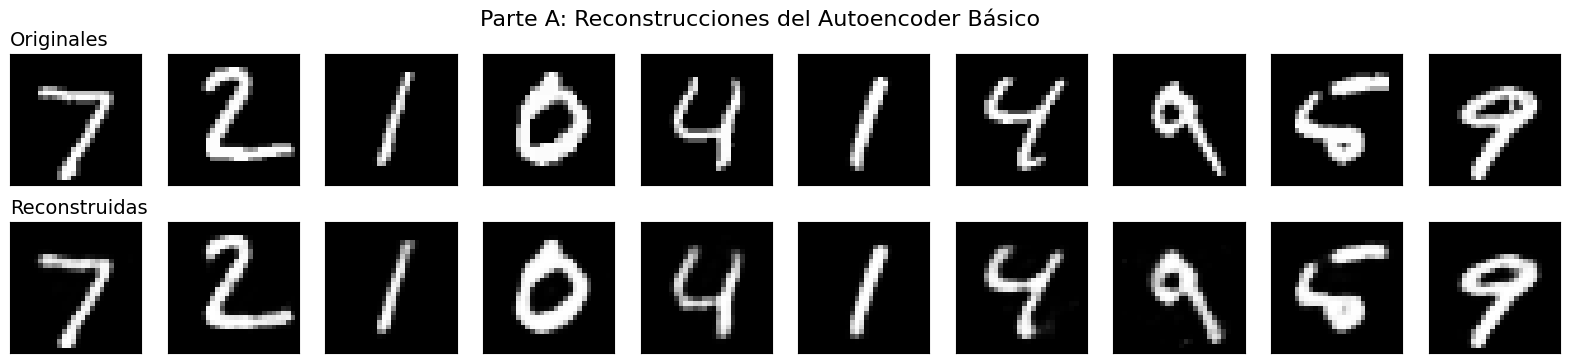

In [18]:
# Usamos el modelo entrenado para predecir (reconstruir) las imágenes del conjunto de prueba.
reconstructed_imgs = autoencoder.predict(x_test)

# --- Visualización de Resultados ---
n = 10  # Número de dígitos a mostrar.
plt.figure(figsize=(20, 4)) # Define el tamaño de la figura que contendrá las imágenes.
plt.suptitle("Parte A: Reconstrucciones del Autoencoder Básico", fontsize=16)

for i in range(n):
    # Mostrar imagen original.
    # Se crea un subplot en la primera fila.
    ax = plt.subplot(2, n, i + 1)
    # Se muestra la i-ésima imagen de prueba, remodelada a 28x28.
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    # Se ocultan los ejes X e Y para una visualización más limpia.
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Se añade un título a la primera imagen de la fila.
    if i == 0: ax.set_title("Originales", loc='left', fontdict={'fontsize': 14})


    # Mostrar imagen reconstruida.
    # Se crea un subplot en la segunda fila.
    ax = plt.subplot(2, n, i + 1 + n)
    # Se muestra la i-ésima imagen reconstruida, remodelada a 28x28.
    plt.imshow(reconstructed_imgs[i].reshape(28, 28), cmap='gray')
    # Se ocultan los ejes.
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Se añade un título a la primera imagen de la fila.
    if i == 0: ax.set_title("Reconstruidas", loc='left', fontdict={'fontsize': 14})

# Muestra la figura con todas las imágenes.
plt.show()

--------

### **Parte B - Autoencoder Denoising**

La segunda parte de la actividad se enfoca en una tarea más avanzada y útil: la **eliminación de ruido**. Un autoencoder *denoising* se entrena para reconstruir una imagen limpia a partir de una entrada corrupta con ruido.

El proceso es el siguiente:

1.  **Generación de Ruido:** Tomaremos las imágenes originales del dataset MNIST y les añadiremos ruido gaussiano. Este ruido simula las imperfecciones que pueden ocurrir en datos del mundo real.
2.  **Entrenamiento Modificado:** La arquitectura del modelo puede ser la misma, pero la clave está en el entrenamiento. Alimentaremos la red con las **imágenes ruidosas** como entrada (`x_train_noisy`) y le pediremos que produzca las **imágenes limpias originales** como salida (`x_train`).

De esta forma, el modelo no puede simplemente aprender a copiar la entrada; se ve forzado a aprender las características estructurales de los dígitos para poder distinguir la "señal" (el dígito) del "ruido" y eliminar este último.

### **Generación de Datos Ruidosos y Entrenamiento**

In [19]:
# --- 1. Generar imágenes ruidosas ---
# Define la intensidad del ruido. Un valor más alto significa más ruido.
noise_factor = 0.5
# Se genera ruido gaussiano con media 0 y desviación estándar 1, con la misma forma que nuestros datos.
# Este ruido se multiplica por el `noise_factor` y se suma a las imágenes originales.
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

# --- Recortar (Clip) los valores ---
# Al sumar el ruido, algunos valores de píxeles pueden salirse del rango [0, 1].
# `np.clip` asegura que todos los valores se mantengan dentro de este rango válido.
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

# --- 2. Construir y entrenar el modelo de Denoising ---
# Podemos usar la misma arquitectura del autoencoder básico.
denoising_autoencoder = autoencoder
# Se compila nuevamente para reiniciar el estado del optimizador.
denoising_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# La diferencia clave está aquí:
# La entrada son las imágenes ruidosas (x_train_noisy).
# El objetivo son las imágenes limpias (x_train).
denoising_autoencoder.fit(
    x_train_noisy,
    x_train,
    epochs=100, # Denoising es una tarea más difícil, por lo que se usan más epochs.
    batch_size=256,
    shuffle=True,
    validation_data=(x_test_noisy, x_test)
)

Epoch 1/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.1969 - val_loss: 0.1372
Epoch 2/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.1336 - val_loss: 0.1241
Epoch 3/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.1230 - val_loss: 0.1189
Epoch 4/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.1183 - val_loss: 0.1164
Epoch 5/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.1159 - val_loss: 0.1148
Epoch 6/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.1143 - val_loss: 0.1140
Epoch 7/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.1132 - val_loss: 0.1131
Epoch 8/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.1125 - val_loss: 0.1127
Epoch 9/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.1119 - val_loss: 0.1126
Epoch 10/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.1113 - val_loss: 0.1122
Epoch 11/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.1110 - val_loss: 0.1112
Epoch 12/100
235/235 ━━━━━━━━━

Como comentamos, el siguiente código se enfoca en el uso de un **autoencoder de eliminación de ruido** (*denoising autoencoder*) para limpiar imágenes corrompidas. El objetivo es visualizar y comparar la capacidad del modelo para reconstruir versiones claras de imágenes que han sido intencionalmente alteradas con ruido.

### **Proceso y Visualización**

El proceso comienza con la predicción, donde el modelo `denoising_autoencoder.predict(x_test_noisy)` toma un conjunto de imágenes ruidosas (`x_test_noisy`) como entrada. La red neuronal ha sido entrenada para reconocer y eliminar el ruido, generando como resultado imágenes `denoised_imgs` que se asemejan a sus contrapartes originales y limpias.

---

La visualización es crucial para evaluar la efectividad del modelo. Se crea un gráfico con `matplotlib` que organiza las imágenes en tres filas para una comparación directa y clara:

* **Fila superior:** Muestra las **imágenes ruidosas** que se le dieron como entrada al modelo.
* **Fila intermedia:** Exhibe las **imágenes limpiadas** o reconstruidas por el autoencoder.
* **Fila inferior:** Presenta las **imágenes originales** (sin ruido) como la verdad fundamental (*ground truth*).

Esta disposición permite al usuario comparar cómo el modelo transformó las imágenes ruidosas y qué tan cerca quedaron de las originales, demostrando su eficacia en la tarea de denoising.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


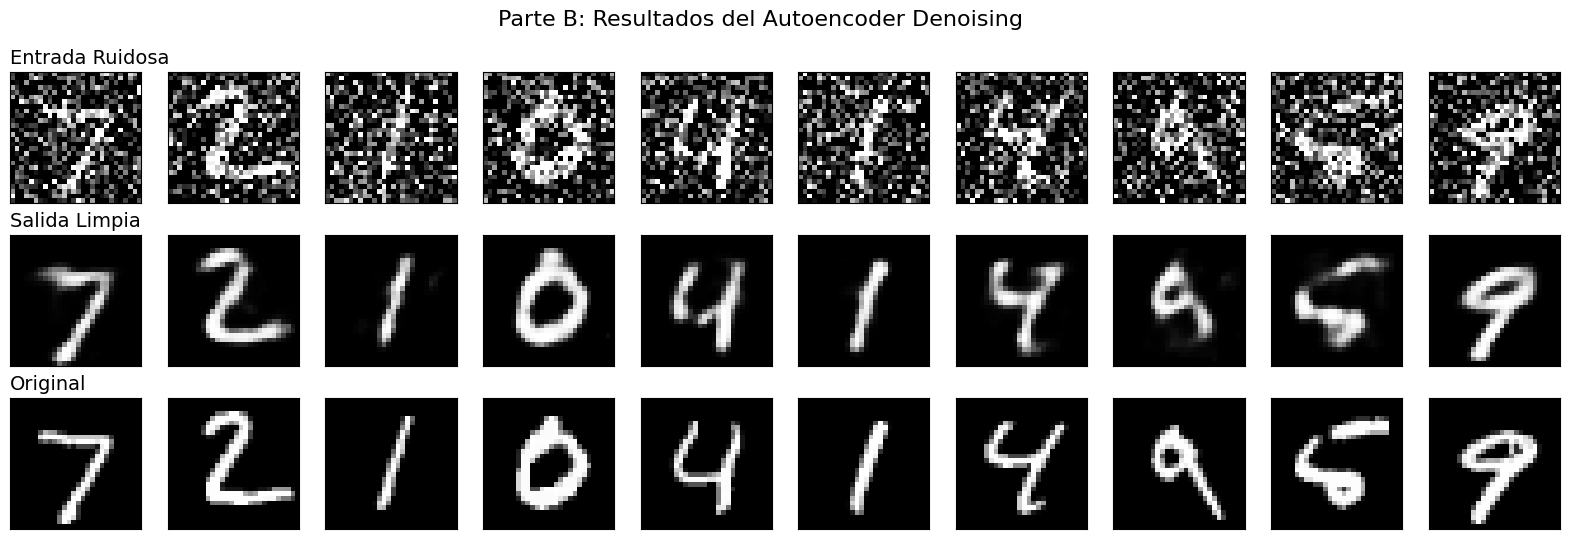

In [20]:
# Usamos el modelo denoising para predecir imágenes limpias a partir de las de prueba ruidosas.
denoised_imgs = denoising_autoencoder.predict(x_test_noisy)

# --- Visualización Comparativa ---
n = 10
plt.figure(figsize=(20, 6))
plt.suptitle("Parte B: Resultados del Autoencoder Denoising", fontsize=16)

for i in range(n):
    # Mostrar entrada ruidosa.
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 0: ax.set_title("Entrada Ruidosa", loc='left', fontdict={'fontsize': 14})


    # Mostrar salida limpia (reconstrucción).
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(denoised_imgs[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 0: ax.set_title("Salida Limpia", loc='left', fontdict={'fontsize': 14})


    # Mostrar imagen original (Ground Truth).
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 0: ax.set_title("Original", loc='left', fontdict={'fontsize': 14})

plt.show()


### **Análisis Comparativo Profesional**

#### Evaluación Cuantitativa (Métricas) 📊

Al final del entrenamiento, cada modelo reporta un valor de `val_loss` (pérdida en el conjunto de validación).

  * **Autoencoder Básico:** Típicamente, alcanza un `val_loss` final **más bajo**. En este caso ronda \~0.075. Esto es esperable, ya que su tarea es una reconstrucción directa. La pérdida mide únicamente el error introducido por el ciclo de compresión-descompresión.
  * **Autoencoder Denoising:** Su `val_loss` final será **más alto**, en estew caso, \~0.10. Esto **no significa que sea un peor modelo**. Al contrario, está resolviendo un problema mucho más difícil: la pérdida no solo mide el error de reconstrucción, sino también el error residual tras eliminar una cantidad significativa de ruido. El valor absoluto de la pérdida es mayor porque la distancia entre la entrada (ruidosa) y la salida (limpia) es intrínsecamente grande. Lo importante es que el modelo logra minimizar esta pérdida, demostrando su capacidad de transformación.

#### Evaluación Cualitativa (Visual) 👁️

  * **Autoencoder Básico:** Las imágenes reconstruidas son muy claras pero a menudo **ligeramente borrosas** en comparación con las originales. Se puede notar una pérdida de detalles finos y bordes menos nítidos. Esto es una consecuencia directa de la compresión con pérdida: el modelo aprendió las características más importantes pero descartó información de alta frecuencia (detalles sutiles).
  * **Autoencoder Denoising:** Los resultados visuales son la evidencia más contundente de su poder. A pesar de recibir entradas muy degradadas, las salidas son **notablemente limpias y legibles**. El modelo no solo reconstruye el dígito, sino que lo "restaura", eliminando el ruido gaussiano de manera efectiva. Aunque la salida puede no ser tan nítida como la del autoencoder básico (ya que parte de la información se pierde irreversiblemente por el ruido), su capacidad para separar la señal del ruido es impresionante.

#### Conclusión Profesional

Ambos modelos son exitosos en sus respectivas tareas. Sin embargo, el **autoencoder de eliminación de ruido demuestra una capacidad de aprendizaje superior y más robusta**. No se limita a aprender una compresión, sino que aprende la **estructura subyacente** o el *manifold* de los datos de los dígitos. Este conocimiento profundo le permite generalizar y reconstruir la esencia de un dígito incluso desde una versión corrupta, una habilidad crucial para aplicaciones en el mundo real donde los datos rara vez son perfectos.

-----

### **Reflexión sobre Aplicaciones Potenciales**

La técnica de autoencoders, especialmente la de eliminación de ruido, tiene un potencial inmenso en múltiples dominios profesionales, donde la integridad y calidad de los datos son primordiales.

#### Medicina 🩺

En el campo de la imagenología médica (MRI, CT, Rayos X), las imágenes a menudo contienen ruido y artefactos que pueden ocultar detalles patológicos cruciales. Un autoencoder *denoising* puede ser entrenado en grandes datasets de imágenes médicas para **limpiar y mejorar la calidad de las exploraciones**. Esto podría permitir a los médicos detectar tumores en etapas más tempranas, identificar fracturas sutiles o mejorar la segmentación de órganos, llevando a diagnósticos más precisos y tratamientos más efectivos.

#### Seguridad 🛡️

En seguridad y vigilancia, las grabaciones de video suelen ser de baja resolución o estar afectadas por malas condiciones de iluminación o ruido de compresión. Los autoencoders pueden **mejorar la calidad de estas imágenes**, facilitando la identificación de rostros o matrículas en investigaciones forenses. Además, en ciberseguridad, los autoencoders son excelentes para la **detección de anomalías**. Entrenados con datos de tráfico de red "normal", pueden identificar patrones anómalos (con un alto error de reconstrucción) que podrían indicar un ciberataque o una intrusión en el sistema.

#### Industria y Manufactura 🏭

En las líneas de producción, el control de calidad visual es fundamental. Se puede entrenar un autoencoder con miles de imágenes de productos sin defectos. Durante la producción, el sistema puede analizar imágenes de nuevos productos. Si un producto tiene un defecto (una grieta, una mancha, una deformidad), el modelo no podrá reconstruirlo con un error bajo. Este **alto error de reconstrucción** serviría como una señal para rechazar automáticamente el producto defectuoso, automatizando y mejorando la precisión del control de calidad 24/7.